# Churn Prediction with XGBoost: Data Preparation and Model Building

# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">1. Introduction</p>
This notebook is dedicated to the preparation and development of a machine learning model for predicting customer churn using XGBoost. Building on insights gained from the exploratory data analysis (EDA) phase (Refer to my notebook: https://www.kaggle.com/code/yorkyong/bank-churn-eda-insights-through-data#Summary-and-Conclusion), we will leverage pipelines and feature engineering techniques to enhance the predictive capabilities of our model.



## Data Preparation

### Categorical Fields
A notable observation during EDA was the prevalence of numeric nature in many categorical fields, eliminating the need for additional encoding. This simplifies the data preparation process and allows us to focus on other aspects of feature engineering.

### Numeric Variable Relationships
Analysis of the correlation heatmap revealed that most numeric variables lack a strong linear relationship. However, patterns identified in the pair plot, particularly those involving 'Age' and 'NumofProds' concerning 'Exited,' highlight potential strong candidates for feature inclusion in the machine learning model.

### Feature Relevance
Customer ID and Surname, based on our analysis, do not contribute significantly to modeling and predicting churn. Therefore, they will be excluded from the feature set to enhance model efficiency.

### Additional Considerations

- **Binning for Age and Estimated Salary:** Exploring the utility of binning to capture non-linear patterns in 'Age' and 'Estimated Salary.'

- **Clustering for Persona/Segments:** Utilizing clustering techniques to create customer personas or segments, enhancing the model's ability to predict churn through targeted insights.

- **Balance Feature Engineering:** Introducing two new features, 'Balance_is_zero' (binary) and 'Non_zero_balance' (copy of 'Balance' if non-zero), to incorporate nuanced information related to customer balances.

The subsequent sections will delve into the implementation of these data preparation steps, culminating in the construction and evaluation of an XGBoost-based machine learning model.

# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">2. Import Libraries</p>

In [1]:
#Basic libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn library
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from xgboost import plot_importance

# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">3. Load Data</p>

In [2]:
sample = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv', index_col = 'id')
trainX = train.drop(['Exited'], axis=1)
trainy = train['Exited']
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv', index_col = 'id')

In [3]:
sample.head()

,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [4]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [5]:
test.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">4. Data Preparation</p>


This code defines custom transformer classes for scikit-learn's preprocessing pipeline. These transformers inherit from the scikit-learn classes but extend their functionality by adding methods to retrieve feature names after transformation. Additionally, there are custom transformers for handling identity transformations and feature unions.

Here's a brief summary of each class:

* SimpleImputerNamed: Inherits from scikit-learn's SimpleImputer class. It extends the functionality to include a method (get_feature_names_out) that returns the feature names after transformation.

* OrdinalEncoderNamed: Inherits from scikit-learn's OrdinalEncoder class. Similar to SimpleImputerNamed, it includes a method to get feature names after transformation.

* OneHotEncoderNamed: Inherits from scikit-learn's OneHotEncoder class. It includes a method (get_feature_names_out) that returns the feature names after one-hot encoding.

* ColumnTransformerNamed: Inherits from scikit-learn's ColumnTransformer class. It extends the functionality to include a method (get_feature_names_out) that returns the feature names after applying transformations.

* Identity and IdentityNamed: Custom transformer classes for identity transformations. IdentityNamed includes a method to get feature names, making it compatible with scikit-learn transformers.

* FeatureUnionNamed: Inherits from scikit-learn's FeatureUnion class. It extends the functionality to include a method (get_feature_names_out) that returns the feature names after applying transformations.

These custom classes provide enhanced flexibility when working with scikit-learn pipelines by allowing the retrieval of feature names, which can be useful for subsequent analysis and interpretation.

In [6]:
class SimpleImputerNamed(SimpleImputer):
    from sklearn.impute import SimpleImputer
    def get_feature_names_out(self):
        return list(self.feature_names_in_)
class OrdinalEncoderNamed(OrdinalEncoder):
    def get_feature_names_out(self):
        return list(self.feature_names_in_)
class OneHotEncoderNamed(OneHotEncoder):
    def get_feature_names_out(self):
        names_out = []
        for i, name_in in enumerate(self.feature_names_in_):
            names_out += [f'{name_in}_{j}' for j in self.categories_[i]]
        return names_out
class ColumnTransformerNamed(ColumnTransformer):
    def get_feature_names_out(self):
        names = []
        for transformer in self.transformers_:
            if transformer[0] == 'remainder':
                if transformer[1] == 'passthrough':
                    names += list(self.feature_names_in_[transformer[2]])
                break
            else:
                names += transformer[1].get_feature_names_out()
        return names
    def fit(self, X, y=None):
        #print('In fit method')
        return super().fit(X,y)
    def transform(self, X):
        #print('In transform method')
        transformed = super().transform(X)
        return pd.DataFrame(transformed, columns= self.get_feature_names_out())
    def fit_transform(self, X, y=None):
        #print('In fit_transform method')
        fit_transformed = super().fit_transform(X,y)
        return pd.DataFrame(fit_transformed, columns=self.get_feature_names_out())
    


class Identity(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.array(X)
class IdentityNamed(Identity):
    def fit(self, X, y=None):
        self.feature_names_in_ = list(X.columns)
        return self
    def get_feature_names_out(self):
        return self.feature_names_in_
    
class FeatureUnionNamed(FeatureUnion):
    def __init__(self, transformer_list):
        self.transformers_ = transformer_list
        super().__init__(transformer_list)
    def get_feature_names_out(self):
        names = []
        for transformer in self.transformers_:
            names += transformer[1].get_feature_names_out()
        return names
    def fit(self, X, y=None):
        return super().fit(X,y)
    def transform(self, X):
        transformed = super().transform(X)
        return pd.DataFrame(transformed, columns= self.get_feature_names_out())
    def fit_transform(self, X, y=None):
        print(X.shape)
        fit_transformed = super().fit_transform(X,y)
        return pd.DataFrame(fit_transformed, columns=self.get_feature_names_out())

# Column Transformer

In [7]:
#applies transformers to different columns.
multicolumn_prep = ColumnTransformer([ ('encode', 
                                       OneHotEncoder(handle_unknown='ignore'), 
                                       ['Gender', 'Geography']),
                                     ],
                                     remainder='passthrough')
multicolumn_prep

ColumnTransformer(remainder='passthrough',
                  transformers=[('encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Geography'])])

In [8]:
#Connect ColumnTransformer to Model
ct_pipeline = Pipeline([('preprocessing', multicolumn_prep),
                        ('XGBClass', XGBClassifier(learning_rate = 0.01, gamma = 0.05, n_estimators = 120,random_state=0))])
ct_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Geography'])])),
                ('XGBClass',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_ca...
                               feature_types=None, gamma=0.05, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=120, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

# Baseline Model and scoring
* Receiver Operating Characteristic - Area Under the Curve (ROC-AUC) score is a performance metric commonly used in binary classification problems.
* Receiver Operating Characteristic (ROC) Curve: A graphical representation of the model's ability to discriminate between positive and negative classes across different threshold values.
* Area Under the Curve (AUC): The area under the ROC curve. AUC provides a single scalar value that summarizes the overall performance of the model. A higher AUC indicates better discrimination between the positive and negative classes.

**Interpretation of Scores:**
* 0.5 to 0.6: Poor discrimination
* 0.6 to 0.7: Fair discrimination
* 0.7 to 0.8: Good discrimination
* 0.8 to 0.9: Very good discrimination
* 0.9 to 1.0: Excellent discrimination

In [9]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
ct_cv_res = cross_validate(estimator = ct_pipeline, 
                           X = trainX.drop(['CustomerId', 'Surname'],
                                           axis=1),
                           y = trainy,
                           cv = skf,
                           scoring = 'roc_auc')['test_score'].mean()
print(f"Average cross-validated ROC_AUC from\ncolumn transformer pipeline: {ct_cv_res:.5f}")

Average cross-validated ROC_AUC from
column transformer pipeline: 0.88601


# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">5. Feature Engineering</p>

#  Custom transformer - Age binning

In [10]:
class AgeBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['Age'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Age',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
AgeBinning(10).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,QCut10_Age
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,2
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,2
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,6
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,2
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,3
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1


#  Custom transformer - Estimated Salary Binning

In [11]:
class SalaryBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['EstimatedSalary'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Est_Salary',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
SalaryBinning(10).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,QCut10_Est_Salary
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,9
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,9
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,3
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,5
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,5
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,5


#  k-Means Clustering

In [12]:
class KMeansClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, features, n_clusters=20, random_state=0, n_components=None):
        self.features = features
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=random_state)
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)

    def fit(self, X, y=None):
        X_scaled = self.scaler.fit_transform(X.loc[:, self.features])
        if self.n_components is not None:
            X_scaled = self.pca.fit_transform(X_scaled)
        self.kmeans.fit(X_scaled)
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X.loc[:, self.features])
        if self.n_components is not None:
            X_scaled = self.pca.transform(X_scaled)
        X_new = pd.DataFrame()
        X_new["Cluster"] = self.kmeans.predict(X_scaled)
        
        X_copy = X.copy()
        # Convert the "Cluster" column to dense format
        X_new["Cluster"] = X_new["Cluster"].values
        return pd.concat([X_copy.reset_index(drop=True), X_new.reset_index(drop=True)], axis=1)

In [13]:
#With PCA (specify the number of components, e.g., 3)
clusterer_with_pca = KMeansClusterer(features=["CreditScore","Age","Balance"], n_clusters=20, random_state=123, n_components=3)

# Fit and transform your data
clusterer_with_pca.fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Cluster
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,15
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,4
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,15
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,18
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,15
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,5
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,0
165032,15689614,Hsiung,554,Spain,Female,30.0,7,161533.00,1,0.0,1.0,71173.03,0,18


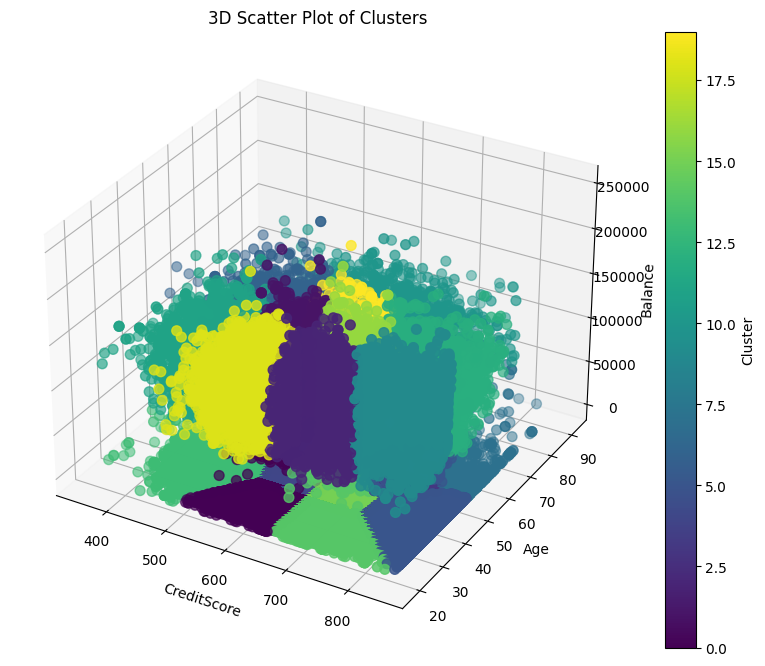

In [14]:
#Visualising the clusters
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_train is your training data
X_train_selected = train[["CreditScore", "Age", "Balance"]]

# Fit and transform with PCA and KMeansClusterer
clusterer_with_pca.fit(X_train_selected)
X_transformed = clusterer_with_pca.transform(X_train_selected)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points colored by cluster
scatter = ax.scatter(X_transformed["CreditScore"], X_transformed["Age"], X_transformed["Balance"], c=X_transformed["Cluster"], cmap='viridis', s=50)

# Add labels and title
ax.set_xlabel('CreditScore')
ax.set_ylabel('Age')
ax.set_zlabel('Balance')
ax.set_title('3D Scatter Plot of Clusters')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()

#  Custom transformer - Zero Balance

In [15]:
class BalanceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a binary column indicating if the bank account is zero
        X['Balance_is_zero'] = (X['Balance'] == 0).astype(int)
        
               
        Balance_is_zero_series = pd.Series(X['Balance_is_zero'], 
                                           name='Balance_is_zero',
                                           index=X.index)
        return X
            
BalanceTransformer().fit_transform(train)


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Balance_is_zero
id,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,1
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,15667085,Meng,667,Spain,Female,33.0,2,0.00,1,1.0,1.0,131834.75,0,1
165030,15665521,Okechukwu,792,France,Male,35.0,3,0.00,1,0.0,0.0,131834.45,0,1
165031,15664752,Hsia,565,France,Male,31.0,5,0.00,1,1.0,1.0,127429.56,0,1


# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">6. Assembling the Pipeline</p>

# Drop columns

In [16]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)

In [17]:
named_preprocessing_pipeline = Pipeline([
                                         ('kmeans', KMeansClusterer(features=["CreditScore","Age","Balance"], n_clusters=20, random_state=123, n_components=3)),
                                         ('salary_binning', SalaryBinning(10)),
                                         ('age_binning', AgeBinning(10)),
                                         ('balance_binning', BalanceTransformer()),
                                         ('drop', DropColumn(cols=['CustomerId','Surname'])),
                                         ('prep',ColumnTransformer([ ('encode', 
                                                                      OneHotEncoder(handle_unknown='ignore',sparse_output=False), 
                                                                      ['Gender', 'Geography']),
                                                                   ],
                                                                   remainder='passthrough').set_output(transform='pandas')),
                                        ])
named_preprocessing_pipeline
                                

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CreditScore', 'Age', 'Balance'],
                                 n_components=3, random_state=123)),
                ('salary_binning', SalaryBinning(n_bins=10)),
                ('age_binning', AgeBinning(n_bins=10)),
                ('balance_binning', BalanceTransformer()),
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Geography'])]))])

In [18]:
named_preprocessing_pipeline.fit_transform(train.drop(['Exited'], axis=1))

,encode__Gender_Female,encode__Gender_Male,encode__Geography_France,encode__Geography_Germany,encode__Geography_Spain,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary,remainder__Balance_is_zero,remainder__Cluster,remainder__QCut10_Est_Salary,remainder__QCut10_Age
0,0.0,1.0,1.0,0.0,0.0,668,33.0,3,0.00,2,1.0,0.0,181449.97,1,15,9,2
1,0.0,1.0,1.0,0.0,0.0,627,33.0,1,0.00,2,1.0,1.0,49503.50,1,4,1,2
2,0.0,1.0,1.0,0.0,0.0,678,40.0,10,0.00,2,1.0,0.0,184866.69,1,15,9,6
3,0.0,1.0,1.0,0.0,0.0,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,18,3,3
4,0.0,1.0,0.0,0.0,1.0,716,33.0,5,0.00,2,1.0,1.0,15068.83,1,15,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165029,1.0,0.0,0.0,0.0,1.0,667,33.0,2,0.00,1,1.0,1.0,131834.75,1,15,5,2
165030,0.0,1.0,1.0,0.0,0.0,792,35.0,3,0.00,1,0.0,0.0,131834.45,1,5,5,3
165031,0.0,1.0,1.0,0.0,0.0,565,31.0,5,0.00,1,1.0,1.0,127429.56,1,0,5,1
165032,1.0,0.0,0.0,0.0,1.0,554,30.0,7,161533.00,1,0.0,1.0,71173.03,0,18,2,1


In [19]:
pd.DataFrame(named_preprocessing_pipeline.transform(test))

,encode__Gender_Female,encode__Gender_Male,encode__Geography_France,encode__Geography_Germany,encode__Geography_Spain,remainder__CreditScore,remainder__Age,remainder__Tenure,remainder__Balance,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__EstimatedSalary,remainder__Balance_is_zero,remainder__Cluster,remainder__QCut10_Est_Salary,remainder__QCut10_Age
0,1.0,0.0,1.0,0.0,0.0,586,23.0,2,0.00,2,0.0,1.0,160976.75,1,0,7,0
1,1.0,0.0,1.0,0.0,0.0,683,46.0,2,0.00,1,1.0,0.0,72549.27,1,3,2,8
2,1.0,0.0,1.0,0.0,0.0,656,34.0,7,0.00,2,1.0,0.0,138882.09,1,4,6,3
3,0.0,1.0,1.0,0.0,0.0,681,36.0,8,0.00,1,1.0,0.0,113931.57,1,15,4,4
4,0.0,1.0,0.0,1.0,0.0,752,38.0,10,121263.62,1,1.0,0.0,139431.00,0,16,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110018,0.0,1.0,0.0,0.0,1.0,570,29.0,7,116099.82,1,1.0,1.0,148087.62,0,18,7,1
110019,1.0,0.0,1.0,0.0,0.0,575,36.0,4,178032.53,1,1.0,1.0,42181.68,0,1,0,4
110020,0.0,1.0,1.0,0.0,0.0,712,31.0,2,0.00,2,1.0,0.0,16287.38,1,14,0,1
110021,1.0,0.0,1.0,0.0,0.0,709,32.0,3,0.00,1,1.0,1.0,158816.58,1,14,7,2


# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">7. Modelling with the Pipeline</p>

# Normalisation - StandardScaler

In [20]:
class StandardScalerNamed(StandardScaler):
    def get_feature_names_out(self, X, y=None):
        print(X.columns)
        return X.columns
    def transform(self,X,y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)
modelling_pipeline = Pipeline(named_preprocessing_pipeline.steps + \
                              [('scale',StandardScaler().set_output(transform='pandas')),
                               ('XGBClass', XGBClassifier(learning_rate = 0.01, gamma = 0.05, n_estimators = 120,random_state=123))])
modelling_pipeline

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CreditScore', 'Age', 'Balance'],
                                 n_components=3, random_state=123)),
                ('salary_binning', SalaryBinning(n_bins=10)),
                ('age_binning', AgeBinning(n_bins=10)),
                ('balance_binning', BalanceTransformer()),
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transform...
                               feature_types=None, gamma=0.05, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=120, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

In [21]:
%%time
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
pipeline_cv = cross_validate(estimator = modelling_pipeline,
                             X = train.drop(['Exited'], axis=1),
                             y = train['Exited'],
                             cv = skf,
                             scoring = 'roc_auc')['test_score'].mean()
print(f"Average cross-validated ROC_AUC from\nfinal pipeline: {pipeline_cv:.5f}")

Average cross-validated ROC_AUC from
final pipeline: 0.88598
CPU times: user 3min 28s, sys: 40.4 s, total: 4min 8s
Wall time: 1min 4s


**Note:** Our baseline run was at 0.88601 and the default run with features added was slightly worse-off at 0.88598. Nonetheless, the performance could still be better after we perform Hyperparameter tuning later to find the most ideal parameters to use.

<Figure size 1000x600 with 0 Axes>

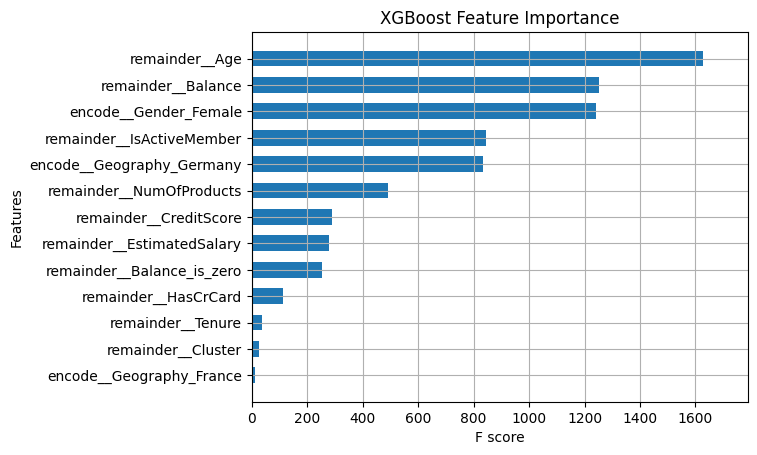

CPU times: user 1min 36s, sys: 18.5 s, total: 1min 55s
Wall time: 29.8 s


In [22]:
%%time
X = train.drop(['Exited'], axis=1)
y = train['Exited']

modelling_pipeline.fit(X, y)
xgb_model = modelling_pipeline.named_steps['XGBClass']

plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', max_num_features=15, height=0.6, show_values=False)
plt.title('XGBoost Feature Importance')
plt.show()

# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">8. Tuning with GridSearch</p>

In [23]:
#tunable parameters
tunable_params = modelling_pipeline.get_params()

# Print the list of tunable parameters and their values
for param, value in tunable_params.items():
    print(f"{param}: {value}")

memory: None
steps: [('kmeans', KMeansClusterer(features=['CreditScore', 'Age', 'Balance'], n_components=3,
                random_state=123)), ('salary_binning', SalaryBinning(n_bins=10)), ('age_binning', AgeBinning(n_bins=10)), ('balance_binning', BalanceTransformer()), ('drop', DropColumn(cols=['CustomerId', 'Surname'])), ('prep', ColumnTransformer(remainder='passthrough',
                  transformers=[('encode',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['Gender', 'Geography'])])), ('scale', StandardScaler()), ('XGBClass', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.05, grow_policy=None, importance_

# Checking time taken for one interation of 4 parameters tuned

In [24]:
# import time
# from sklearn.model_selection import GridSearchCV

# # Define a simplified parameter grid
# param_grid_subset = {
#     'XGBClass__learning_rate': [0.01],
#     'XGBClass__n_estimators': [50],
#     'salary_binning__n_bins': [5],
#     'age_binning__n_bins': [5]
# }

# # Use the correct step name ('xgb' in this case) as the prefix in param_grid_subset
# gscv_roc_subset = GridSearchCV(estimator=modelling_pipeline,
#                                cv=skf,
#                                scoring='roc_auc',
#                                verbose=0,
#                                param_grid=param_grid_subset)

# # Record the start time
# start_time_subset = time.time()

# # Run the GridSearchCV with the smaller subset
# gscv_roc_subset.fit(X=train.drop(['Exited'], axis=1), y=train['Exited'])

# # Record the end time
# end_time_subset = time.time()

# # Calculate the elapsed time for the trial run
# elapsed_time_subset = end_time_subset - start_time_subset

# print(f"Elapsed time for the trial run: {elapsed_time_subset:.2f} seconds")

As one iteration => Elapsed time for the trial run: 112.35 seconds.
So with the settings below it will take approx 45mins to run this GridSearchCV

In [25]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'XGBClass__learning_rate': [0.01, 0.05],
    'XGBClass__n_estimators': [50, 120],
    'salary_binning__n_bins': [5, 10],
    'age_binning__n_bins': [5, 10, 15]
    
}

gscv_roc = GridSearchCV(estimator=modelling_pipeline,
                        cv=skf,
                        scoring='roc_auc',
                        verbose=0,
                        param_grid=param_grid)

CPU times: user 34 µs, sys: 6 µs, total: 40 µs
Wall time: 45.3 µs


In [26]:
# Fit the GridSearchCV
_ = gscv_roc.fit(X=train.drop(['Exited'], axis=1),
                  y=train['Exited'])

In [27]:
cv_res = pd.DataFrame({k:[[str(y)[:6] for y in x] for x in [gscv_roc.cv_results_['param_'+param_name].data for \
                                      param_name in gscv_roc.param_grid]][i] for \
                 i,k in enumerate(gscv_roc.param_grid)})
cv_res['mean_cross_validated_ROC_AUC'] = gscv_roc.cv_results_['mean_test_score']
cv_res['rank'] = gscv_roc.cv_results_['rank_test_score']
cv_res.sort_values(by = ['rank'])

,XGBClass__learning_rate,XGBClass__n_estimators,salary_binning__n_bins,age_binning__n_bins,mean_cross_validated_ROC_AUC,rank
20,0.05,120,5,10,0.888892,1
18,0.05,120,5,5,0.888892,1
22,0.05,120,5,15,0.888892,1
23,0.05,120,10,15,0.888882,4
21,0.05,120,10,10,0.888882,4
19,0.05,120,10,5,0.888882,4
16,0.05,50,5,15,0.887607,7
14,0.05,50,5,10,0.887607,7
12,0.05,50,5,5,0.887607,7
17,0.05,50,10,15,0.887607,10


In [28]:
print("Best parameters:", gscv_roc.best_params_)

Best parameters: {'XGBClass__learning_rate': 0.05, 'XGBClass__n_estimators': 120, 'age_binning__n_bins': 5, 'salary_binning__n_bins': 5}


In [29]:
# Get the best hyperparameters from GridSearchCV
best_hyperparameters = gscv_roc.best_params_


# Used for Logistic Regression
# # Update the logistic regression hyperparameter in the pipeline
# modelling_pipeline.set_params(logreg__C=best_hyperparameters['logreg__C'])

# Update the entire pipeline with the best hyperparameters
modelling_pipeline.set_params(**best_hyperparameters)

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CreditScore', 'Age', 'Balance'],
                                 n_components=3, random_state=123)),
                ('salary_binning', SalaryBinning(n_bins=5)),
                ('age_binning', AgeBinning(n_bins=5)),
                ('balance_binning', BalanceTransformer()),
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformer...
                               feature_types=None, gamma=0.05, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=120, n_jobs=None,
                               num_parallel_tree=None, random_state=123, ...))])

# <p style="background-color:Orange;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">9. Creating Submission file</p>

In [30]:
# fit the model with the updated hyperparameters
modelling_pipeline.fit(X=train.drop(['Exited'], axis=1),
                       y=train['Exited'])

# Create submission file
predictions = modelling_pipeline.predict(test)
sample['Exited'] = predictions
sample.to_csv('submission.csv', index=False)

In [31]:
sample.head()

,id,Exited
0,165034,0
1,165035,1
2,165036,0
3,165037,0
4,165038,0
